In [1]:
''' Let's create a simple CNN model in Keras, using a dataset of handwritten digits. 
       
    Reference tutorials,
        https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
        
    Data source: http://yann.lecun.com/exdb/mnist/index.html
'''

import os, gzip, itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

BASE_DIR = '../../datasets/learn_statistics/classification/digits/'
MY_DATA_DIR = '../../mydatadir/learn_statistics/classification/digits/'

im_w, im_h, im_c = 28, 28, 1
N = 60000  # 60,000 total

In [2]:
# Load the datasets into X and y
# Please see MNIST documentation for dataset information

X = np.empty(shape=(N, im_w, im_h, im_c), dtype=float)
y = np.empty(shape=N, dtype=int)

# Training images
with gzip.open(os.path.join(BASE_DIR, 'train-images-idx3-ubyte.gz'),'rb') as f:
    f.read(16)
    buf = f.read(im_w * im_h * im_c * N)
    X = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    X = X.reshape(N, im_w, im_h, im_c)
# Training labels
with gzip.open(os.path.join(BASE_DIR, 'train-labels-idx1-ubyte.gz'),'rb') as f:
    f.read(8)
    for i in range(0, N):   
        buf = f.read(1)
        label = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        y[i] = label

X = X / 255.0
        
print('X:', X.shape)
print('y:', y.shape)
print('')
print('Memory usage, \n\
  X: {0:.1f} MB, y: {1:.1f} MB'.format(X.nbytes/1e6, y.nbytes/1e6))

X: (60000, 28, 28, 1)
y: (60000,)

Memory usage, 
  X: 188.2 MB, y: 0.5 MB


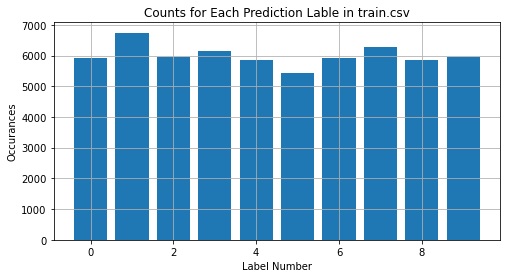

In [3]:
nums, counts = np.unique(y, return_counts=True)

fig, ax = plt.subplots(1, figsize=(8, 4)) 

ax.bar(nums, counts)
ax.set_title('Counts for Each Prediction Lable in train.csv')
ax.set_xlabel('Label Number')
ax.set_ylabel('Occurances')

ax.grid()

In [4]:
y_hot = to_categorical(y, num_classes=10)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y_hot, 
    test_size = 0.1, 
    random_state = 3)

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(54000, 28, 28, 1)
(6000, 28, 28, 1)
(54000, 10)
(6000, 10)


In [5]:
def create_model():
    ''' CNN architechture 
            In -> [ (Conv2D -> relu) * 2
               ->    MaxPool2D 
               ->    Dropout ] * 2 
               -> Flatten 
               -> Dense
               -> Dropout 
               -> Dense
               -> Out  '''

    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))    
    
    optimizer = RMSprop()

    model.compile(optimizer = optimizer, 
                  loss = "categorical_crossentropy", 
                  metrics = ["accuracy"])
    
    return model

In [6]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy')

checkpoint = ModelCheckpoint('01_learn_handwriting.h5', save_best_only = True, 
                             save_weights_only = True)

datagen = ImageDataGenerator(
    featurewise_center = False,  
    samplewise_center = False,  
    featurewise_std_normalization = False,  
    samplewise_std_normalization = False,  
    
    zca_whitening = False,  
    
    # Augment
    rotation_range = 10,  
    zoom_range = 0.1, 
    width_shift_range = 0.1,  
    height_shift_range = 0.1
)

datagen.fit(X_train)

In [7]:
epochs = 7
batch_size = 89

model = create_model()

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs = epochs, 
    validation_data = (X_valid, y_valid),
    steps_per_epoch = X_train.shape[0] // batch_size, 
    callbacks = [learning_rate_reduction, checkpoint]
)

Epoch 1/7
606/606 [==============================] - 110s 181ms/step - loss: 0.3813 - accuracy: 0.8783 - val_loss: 0.0864 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 2/7
606/606 [==============================] - 106s 175ms/step - loss: 0.1330 - accuracy: 0.9610 - val_loss: 0.0379 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 3/7
606/606 [==============================] - 112s 185ms/step - loss: 0.1071 - accuracy: 0.9691 - val_loss: 0.0392 - val_accuracy: 0.9878 - lr: 0.0010
Epoch 4/7
606/606 [==============================] - 112s 184ms/step - loss: 0.0929 - accuracy: 0.9728 - val_loss: 0.0363 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 5/7
606/606 [==============================] - 105s 174ms/step - loss: 0.0849 - accuracy: 0.9761 - val_loss: 0.0288 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 6/7
606/606 [==============================] - 105s 173ms/step - loss: 0.0881 - accuracy: 0.9771 - val_loss: 0.0318 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 7/7
606/606 [==============================] -

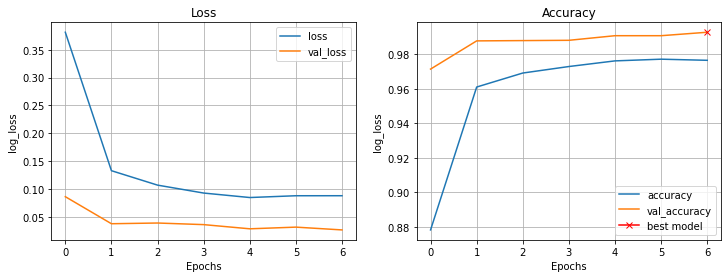

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('log_loss')
ax1.set_title('Loss')
ax1.legend()
ax1.grid()

# Accuracy
ax2.plot(history.history['accuracy'], label='accuracy')
ax2.plot(history.history['val_accuracy'], label='val_accuracy')
ax2.plot(np.argmax(history.history["val_accuracy"]), 
         np.max(history.history["val_accuracy"]), 
                marker='x', color='r', label='best model')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('log_loss')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid()

plt.show()

In [9]:
# Load the best model
model.load_weights('01_learn_handwriting.h5')

In [10]:
model.evaluate(X_valid, y_valid, verbose=1)

188/188 [==============================] - 5s 27ms/step - loss: 0.0268 - accuracy: 0.9927


[0.02681812457740307, 0.9926666617393494]

In [11]:
y_pred_prob = model.predict(X_valid)
y_pred = np.argmax(y_pred_prob, axis=1) 
y_true = np.argmax(y_valid, axis=1)

Cm = np.array(confusion_matrix(y_true, y_pred))

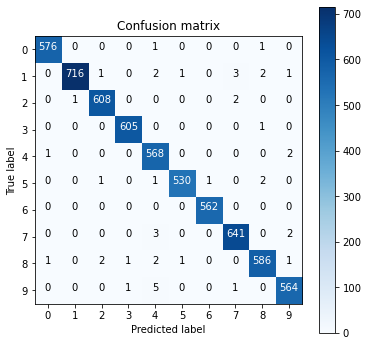

In [12]:
fig, ax = plt.subplots(1, figsize=(6, 6))

im = ax.imshow(Cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(im)

ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

thresh = Cm.max() / 2.
for i, j in itertools.product(range(Cm.shape[0]), 
                              range(Cm.shape[1])):
    ax.text(j, i, Cm[i, j],
             horizontalalignment = "center",
             color= "white" if Cm[i, j] > thresh else "black")

ticks = list(range(10))
tick_labels = np.arange(len(ticks))
    
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels)

plt.show()

In [13]:
idx_err = np.argwhere((y_pred - y_true != 0)).flatten()

# Probabilities of the mistaken predictions
y_pred_prob_errors = np.max(y_pred_prob[idx_err], axis=1)
# Probabilities of the true values, where mistaken
true_prob_errors = np.empty(shape=len(idx_err), dtype=float)
for i, idx in enumerate(idx_err):
    true = y_true[idx]
    probabilites = y_pred_prob[idx].flatten()
    true_prob_errors[i] = probabilites[true]

# Define the most significant errors
delta_err = y_pred_prob_errors - true_prob_errors
idx = np.argsort(delta_err)
idx_errors_sorted = idx_err[idx[::-1]]

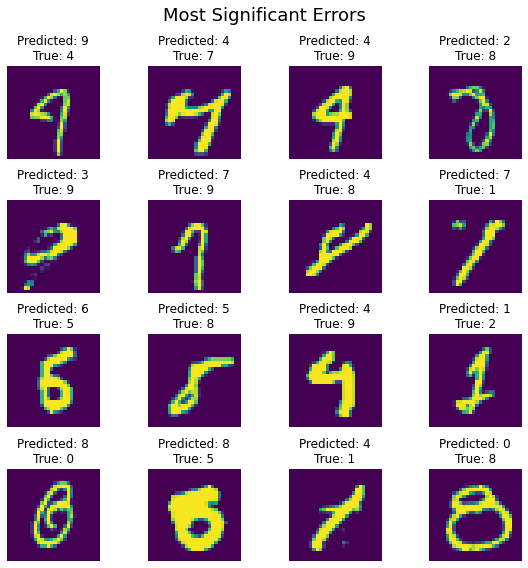

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

n = 0
nrows = 4
ncols = 4

for i, ax in enumerate(axes.flatten()):
    
    idx = idx_errors_sorted[i]
    ax.imshow(X_valid[idx])
    
    s = "Predicted: {0:d}\nTrue: {1:d}".format(y_pred[idx] , y_true[idx])
    ax.set_title(s)
    ax.axis('off')
    
fig.suptitle('Most Significant Errors', fontsize=18)
fig.tight_layout()